<a href="https://colab.research.google.com/github/pipeton8/6.439-stats-comp-applications/blob/main/Assignments/4%20-%20Networks/6.439%20-%20Problem%20Set%204.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Set 4 - Statistics, Computation and Applications

(c) Felipe del Canto, November 2021
***
***

# Part 0 (Execute first!)

In [1]:
# Set load = True to load co-offending network (faster)
load = True

## Packages

In [2]:
from IPython.display import clear_output

# Download files
!wget https://github.com/pipeton8/6.439-stats-comp-applications/raw/main/Assignments/databases/PS4_data.zip

# Unzip
!unzip -o PS4_data.zip
!rm *.z* -r __MACOSX

# Clear output
clear_output()

# Import packages
import warnings
import scipy
import csv

import numpy  as np
import pandas as pd
pd.options.display.float_format = '{:.4f}'.format

import seaborn           as sns
import matplotlib.pyplot as plt
import networkx          as nx 

from tqdm.auto import tqdm, trange

## Functions

In [3]:
# Function to create or loadd the co-offending network
def create_co_off_network(co_off, load=True, save=True, file_path = 'co_off_network.npz'):
  """ 
  Given a dataframe with event_id and offender_id as variables, create the
  co offending network as a dok sparse matrix. If the `save` option is set to 
  true, store the network in .npz format in filename co_off_network.npz.

  If the `load` option is set to true, do not create the network and, instead,
  load the co_off_network.npz file.

  Specific file paths and filenames can be set using the `file_path` optional
  argument.
  """

  if not load:
    # Obtain crime events
    crime_events = co_off['event_id'].unique()

    # Loop over the crime events
    for event in tqdm(crime_events, desc="Creating co-offending network"):

      # Restrict dataset to current event_id
      event_data = co_off[co_off['event_id'] == event]

      # Obtain list of offenders
      offenders = event_data['offender_id'].to_numpy()

      # Cycle through offenders to increase by 1 their co-offending weight
      for i,offender_i in enumerate(offenders):
        for offender_j in offenders[i:]:
          co_off_network[offender_i, offender_j] += 1
          co_off_network[offender_j, offender_i] += 1
    
    # Save sparse matrix
    if save:
      co_off_network_coo = co_off_network.tocoo(copy=True)
      scipy.sparse.save_npz(file_path, co_off_network_coo)
      del co_off_network_coo
    
  else:
    co_off_network_coo = scipy.sparse.load_npz(file_path)
    co_off_network = co_off_network_coo.todok(copy=True)
    del co_off_network_coo
  
  return co_off_network

In [4]:
def remove_solo_offenders(network):
  """ 
  Given a dok sparse matrix, return the updated dok matrix where the 
  nodes with degree 1 are removed. 
  """

  assert type(network) == scipy.sparse.dok_matrix

  # Convert to lil for faster row slicing
  network_copy = network.tolil(copy=True)

  # Store rows
  network_rows = network_copy.rows.copy()

  # Check with nodes are solo offender
  for i,row in tqdm(enumerate(network_rows), total=len(network_rows), desc="Removing solo offenders"):
    if len(row) == 1:
      network[i,row[0]] = 0
    
  # Save memory
  del network_copy, network_rows

  return network

In [5]:
def print_nodes_and_edges(network, title, final_space=True):
  """
   Given a dok sparse matrix, print the number of nodes and edges in a "fancy"
   way. Edges are also split in self and non-self edges.
  """

  assert type(network) == scipy.sparse.dok_matrix

  # Compute number of nodes and edges
  total_nodes          = network.shape[0]
  total_self_edges     = (network.diagonal() != 0).sum()
  total_edges          = (len(network.keys()) + total_self_edges)//2
  total_not_self_edges = (len(network.keys()) - total_self_edges)//2

  # Print number of nodes and edges
  print(title)
  print("-"*len(title))
  print(f" - There are a total of {total_nodes:,} nodes.")
  print(f" - There are a total of {total_edges:,} edges.")
  print(f"    • Of these, {total_self_edges:,} are self edges.")
  print(f"    • Of these, {total_not_self_edges:,} are not self edges.")

  if final_space:
    print()
  
  return None

In [6]:
def print_degree_counts(up_to, degree_sequence, counts):
  """
  Given a list of max degrees, a degree sequence and the counts of each degree,
  prints the cumulative sum of nodes with positive degree with at most `max_degree`,
  where `max_degree` is each one of the elements of list `up_to`. This is also
  displayed as a percentage. 
  """

  if type(up_to) is not list:
    up_to = [up_to]

  total_counts = counts.sum()
  print(f"The total number of nodes with positive degree is {total_counts:,}.")

  for i,max_degree in enumerate(up_to):
    counts_up_to_max_degree = counts[:list(degree_sequence).index(max_degree+1)].sum()
    percentage = counts_up_to_max_degree/total_counts * 100

    print(f' - Nodes with degree at most {max_degree}: {counts_up_to_max_degree:,}' +
          f' ({percentage:.2f}%).')

In [7]:
def get_eccentricities(network, load=True, save=True, file_path = "eccentricities.csv"):
  """ 
  Given a networks object `network`, retrieve the eccentricities dictionary. 
  If the `save` option is set to True, save the network in .csv format in 
  filename eccentricities.csv, or the specified path in `file_path`. 
  
  If the `load` option is set to True, do not create the network and, instead,
  load the eccentricities.csv file, or the specified path in `file_path`.
  """
  if not load:
    eccentricities = nx.algorithms.distance_measures.eccentricity(CC_graph)

    if save:
      # open file for writing, "w" is writing
      w = csv.writer(open(file_path, "w"))

      # loop over dictionary keys and values
      for key, val in eccentricities.items():
        # write every key and value to file
        w.writerow([key, val])

  else:
    eccentricities_csv = csv.reader(open(file_path, "r"))
    eccentricities = {int(node): int(eccentricity) for node, eccentricity in eccentricities_csv}

  return eccentricities

In [43]:
def get_betweenness_centrality(network, load=True, save=True, file_path = "betweenness_centrality.csv"):
  """ 
  Given a networks object `network`, retrieve the betweenness centrality dictionary. 
  If the `save` option is set to True, save the network in .csv format in 
  filename betweenness_centrality.csv, or the specified path in `file_path`. 
  
  If the `load` option is set to True, do not create the network and, instead,
  load the betweenness_centrality.csv file, or the specified path in `file_path`.
  """
  if not load:
    betweenness_centrality = nx.algorithms.centrality.betweenness_centrality(CC_graph, endpoints=True)

    if save:
      # open file for writing, "w" is writing
      w = csv.writer(open(file_path, "w"))

      # loop over dictionary keys and values
      for key, val in betweenness_centrality.items():
        # write every key and value to file
        w.writerow([key, val])

  else:
    betweenness_centrality_csv = csv.reader(open(file_path, "r"))
    betweenness_centrality = {int(node): float(betweenness_centrality) 
                                for node, betweenness_centrality in betweenness_centrality_csv
                              }

  return betweenness_centrality

# Problem 4.2: Co-offending Network

## Preamble

In [9]:
# Load data
co_off = pd.read_csv("Cooffending.csv")

# Set date
co_off['date'] = pd.to_datetime(co_off['date'])

## (a), (b), (c), (d): Data exploration

This dataset contains 1,465,786 entries. Each observation is taken at the `offender_id`-`event_id`-`crime_code` level. This is, individual offenders arrested at a given crime event and charged with a certain crime. 

Note that at any given crime event, the offender can be charged several different crimes.





In [10]:
print(f"Total number of entries: {co_off.shape[0]:,}")

Total number of entries: 1,465,786


Within, the number of unique offenders is 538,851, and the number of different crime events are 1,163,423, which occurred between 1997 and 2004 according to the following table:

| Year | Number of arrests |
|:--:|:--:|
| 1997 |	22404  |
| 1998 |	142582 |
| 1999 |	163346 |
| 2000 |	220197 |
| 2001 |	234495 |
| 2002 |	246397 |
| 2003 |	251298 |
| 2004 |	185067 |

In [11]:
co_off[['offender_id', 'event_id']].describe(include='all')

,offender_id,event_id
count,1465786.0000,1465786.0000
mean,281089.4558,581615.2382
std,143657.5503,335671.5310
min,0.0000,0.0000
25%,164215.0000,290578.2500
50%,284490.0000,581769.5000
75%,402317.7500,872052.0000
max,538850.0000,1163422.0000


In [12]:
co_off[['offender_id', 'year']].groupby(['year']).count()

,offender_id
year,
1997,22404
1998,142582
1999,163346
2000,220197
2001,234495
2002,246397
2003,251298
2004,185067


We can observe a total of 301 different crime codes (different offenses). The 5 crimes that occured the most are:

| Crime code | Number of offenses  |
|:----------:|:-------------------:|
| 22         |  140,901            |
| 131        |  108,031            |
| 61         |   94,655            |
| 39         |   90,179            |
| 73         |   83,110            |
| <b> Total  |  516,876            |

Together, they comprise a total of 516,876 perpetrators, and correspond to, approximately, 35% of the sample.

In terms of crimes in general, there is high variability. Moreover, a great number of crimes have low occurrences (see figure below).

In [13]:
print("Number of unique crime codes:", co_off['crime_code'].unique().size)

Number of unique crime codes: 301


In [14]:
group_by_code = co_off.groupby('crime_code').count()

In [15]:
most_offenders = group_by_code.sort_values(by='offender_id', ascending=False).iloc[:5,:]
most_offenders['offender_id']

crime_code
22     140901
131    108031
61      94655
39      90179
73      83110
Name: offender_id, dtype: int64

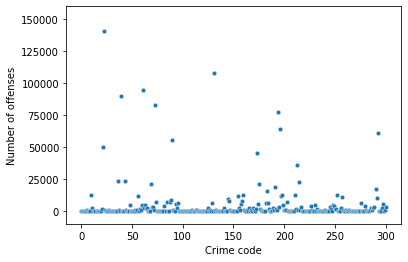

In [16]:
# Axis offsets
offset = (15,10000)

# Initialize figure
fig, ax = plt.subplots()

# Draw histplot using offender_id count as y-axis
sns.scatterplot(data=group_by_code, x='crime_code', y='offender_id', s=20, ax = ax)

# Set xticks
xticks = [50 * k for k in range(7)]
xlabels = xticks

plt.xticks(ticks=xticks, labels=xlabels, rotation=0, horizontalalignment = 'center')
plt.xlim(xticks[0] - offset[0], xticks[-1] + offset[0])

# Set yticks
yticks = [25000 * k for k in range(7)]
ylabels = yticks

plt.yticks(yticks, ylabels)
plt.ylim(yticks[0] - offset[1], yticks[-1] + offset[1])

# Set axis titles
plt.xlabel("Crime code")
plt.ylabel("Number of offenses")

fig.show()

To gain more insight, the sample is restricted to crimes with less or equal than 5,000 offenders. For reference, the average number of offenders per crime is, approximately, 4,869. With this, of the 294 different codes, 254 (86.3%) remain.

The plot changes slightly. Most of the codes have little offenders and, among the rest, there is high variability.

In [17]:
group_by_code_small = group_by_code[group_by_code['offender_id'] <= 5000]
group_by_code_small.shape

(254, 9)

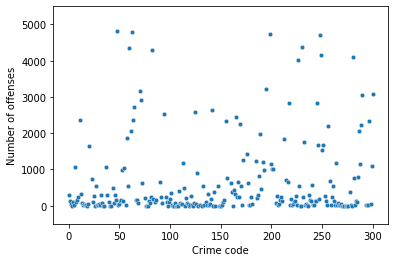

In [18]:
# Axis offsets
offset = (15,500)

# Initialize figure
fig, ax = plt.subplots()

# Draw histplot using offender_id count as y-axis
sns.scatterplot(data=group_by_code_small, x='crime_code', y='offender_id', s=20, ax = ax)

# Set xticks
xticks = [50 * k for k in range(7)]
xlabels = xticks

plt.xticks(ticks=xticks, labels=xlabels, rotation=0, horizontalalignment = 'center')
plt.xlim(xticks[0] - offset[0], xticks[-1] + offset[0])

# Set yticks
yticks = [1000 * k for k in range(6)]
ylabels = yticks

plt.yticks(yticks, ylabels)
plt.ylim(yticks[0] - offset[1], yticks[-1] + offset[1])

# Set axis titles
plt.xlabel("Crime code")
plt.ylabel("Number of offenses")

fig.show()

In terms of location, the most notorious crimes occur mainly in county 682. This could be the most populated county of the database. In fact, for crime 131, this county accounts for 84,952 offenders. This corresponds to, approximately, 78.63% of all offenders arrested for this crime. The following table shows the contribution of this county alone to all the crimes with most offenders:

| Crime code | Offenders in county 682 | Total offenses | Contribution (%) |
|:----------:|:-----------------------:|:---------------:|:----------------:|
| 131       | 84,952                   | 108,031         | 78.63%
|  22       | 28,247                   | 140,901         | 20.05%
|  61       | 24,101                   |  94,655         | 25.46%
|  73       | 23,743                   |  83,110         | 28.57%
|  39       | 21,698                   |  90,179         | 24.06% 

To further see the relevance of this county, the following table shows, for each crime, in how many different counties it occured. Additionally, the table shows the contribution each county should have if crimes occured uniformly in each one. This contribution is computed as follows:
  $$ \text{Contribution}_{\,\text{crime}} = \frac{100}{\text{Number of different counties}_{\,\text{crime}}} $$
<br>

| Crime code | Number of different counties | Uniform contribution |
|:----------:|:----------------------------:|:---------:|
| 131        |   652                        | 0.15%
|  22        | 1,228                        | 0.08%
|  61        | 1,084                        | 0.09%
|  73        | 1,099                        | 0.09%
|  39        | 1,212                        | 0.08%

In [19]:
most_offenders_list = most_offenders.index.to_numpy()
location_of_most_offenders = co_off[co_off['crime_code'].isin(most_offenders_list)]

In [20]:
location_of_most_offenders.groupby(by=['crime_code', 'county']).count().sort_values(by='offender_id').iloc[-5:]

,,offender_id,event_id,adults,date,minors,sex,year,location
crime_code,county,,,,,,,,
39,682,21698,21698,21698,21698,21698,21698,21698,21698
73,682,23743,23743,23743,23743,23743,23743,23743,23743
61,682,24101,24101,24101,24101,24101,24101,24101,24101
22,682,28247,28247,28247,28247,28247,28247,28247,28247
131,682,84952,84952,84952,84952,84952,84952,84952,84952


In [21]:
for crime in most_offenders_list:
  data = location_of_most_offenders[location_of_most_offenders['crime_code'] == crime]
  number_of_counties = data['county'].unique().size
  print(f"Crime code {crime} occured in {number_of_counties} different counties.")

Crime code 22 occured in 1228 different counties.
Crime code 131 occured in 652 different counties.
Crime code 61 occured in 1084 different counties.
Crime code 39 occured in 1212 different counties.
Crime code 73 occured in 1099 different counties.


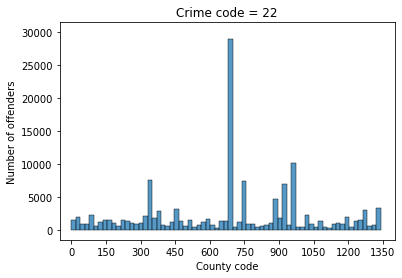

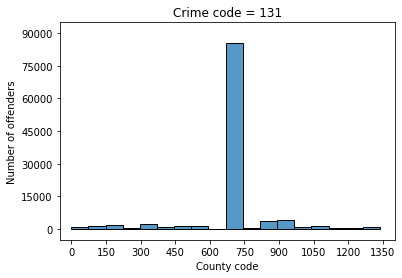

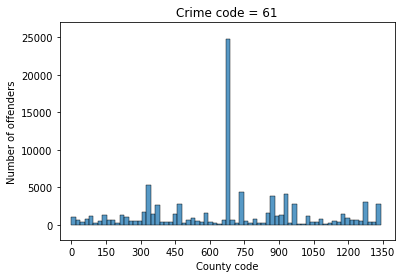

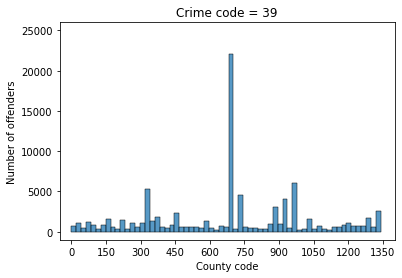

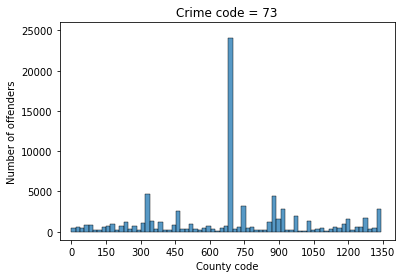

In [22]:
# Axis offsets
offset_x = 50

# yticks dict
yticks_dict = { 22 : ([ 5000 * k for k in range(7)], 1500),
               131 : ([15000 * k for k in range(7)], 5000),
                61 : ([ 5000 * k for k in range(6)], 2000),
                39 : ([ 5000 * k for k in range(6)], 1000),
                73 : ([ 5000 * k for k in range(6)], 1000)
              }

for crime in most_offenders_list:
  # Initialize figure
  fig, ax = plt.subplots()

  # Draw histplot using offender_id count as y-axis
  data = location_of_most_offenders[location_of_most_offenders['crime_code'] == crime]
  sns.histplot(data, x='county')

  # Set xticks
  xticks = [150 * k for k in range(10)]
  xlabels = xticks

  plt.xticks(ticks=xticks, labels=xlabels, rotation=0, horizontalalignment = 'center')
  plt.xlim(xticks[0] - offset_x, xticks[-1] + offset_x)

  # Set yticks
  yticks, offset_y = yticks_dict[crime]
  ylabels = yticks

  plt.yticks(yticks, ylabels)
  plt.ylim(yticks[0] - offset_y, yticks[-1] + offset_y)

  # Set axis titles
  plt.xlabel("County code")
  plt.ylabel("Number of offenders")

  # Set title
  plt.title(f"Crime code = {crime}")

  fig.show()

## (e), (f), (g): Create and analyze the network

To construct the co-offending network, the total number of offenders in the database is obtained. This, since this number determines the size of the co-offending adjacency matrix. Additionally, the sparse matrix object is initialized. Finally, the network is created.

In [23]:
# Initialize parameters
number_of_offenders = co_off['offender_id'].unique().size

# Initialize network as sparse DoK matrix
co_off_network = scipy.sparse.dok_matrix((number_of_offenders,number_of_offenders), dtype='int')

# Create network
co_off_network = create_co_off_network(co_off, load=True)

The table below shows the number of nodes and edges before and after removing solo offenders.

| | With solo offenders | Without solo offenders |
|-:|:-:|:-:|
| Total nodes    | 538,851 | 538,851
| Self edges     | 538,851 | 121,119
| Non-Self edges | 178,372 | 178,372
| Total edges    | 717,223 | 299,491

By construction, the original network (without removing solo offenders) has the same number of self-edges than of nodes (because offenders were arrested with themselves). After removing solo offenders, the total number of self-edges reduces to 121,119, which implies that the total number of solo offenders was 417,732 (= 585,851 - 121,119).

In [24]:
# Show nodes and edges
print_nodes_and_edges(co_off_network, 
                      title="Before removing solo offenders")

# Remove solo offenders
co_off_network = remove_solo_offenders(co_off_network)

# Compute number of nodes and edges
total_nodes          = co_off_network.shape[0]
total_self_edges     = (co_off_network.diagonal() != 0).sum()
total_edges          = len(co_off_network.keys())//2 + total_self_edges//2
total_not_self_edges = len(co_off_network.keys())//2 - total_self_edges//2

# Show nodes and edges
print_nodes_and_edges(co_off_network, 
                      title="\nAfter removing solo offenders", 
                      final_space=False)

Before removing solo offenders
------------------------------
 - There are a total of 538,851 nodes.
 - There are a total of 717,223 edges.
    • Of these, 538,851 are self edges.
    • Of these, 178,372 are not self edges.



Removing solo offenders:   0%|          | 0/538851 [00:00<?, ?it/s]


Before removing solo offenders
-------------------------------
 - There are a total of 538,851 nodes.
 - There are a total of 299,491 edges.
    • Of these, 121,119 are self edges.
    • Of these, 178,372 are not self edges.


Next, the `networkx` module is used to construct a graph object, which makes network analysis easy.

In [25]:
# Initialize graph 
co_off_graph = nx.Graph()

# Add nodes
offender_data = co_off.drop_duplicates(subset=['offender_id'])
nodes = [(off_id, {'sex' : sex}) for off_id, sex in zip(offender_data['offender_id'].to_numpy(), offender_data['sex'].to_numpy())]

co_off_graph.add_nodes_from(nodes)

# Add edges (not considering self-edges)
edges = [(node_i,node_j, {'weight' : weight}) for (node_i,node_j),weight in co_off_network.items() if node_i != node_j]

co_off_graph.add_edges_from(edges)

Next, the degree distribution is obtained. Both figures below show that the degree follows a power-law distribution up to degree -- approximately -- 15 or 20. Afterwards, the lineplot becomes erratic, as fewer nodes have degrees over these caps.

In [26]:
# Obtain degree distribution
degree_sequence = sorted([d for n, d in co_off_graph.degree()])
degree_sequence, counts = np.unique(degree_sequence, return_counts=True)
degree_sequence, counts = degree_sequence[1:], counts[1:]

rel_counts = counts/counts.sum()
cum_counts = rel_counts.cumsum()

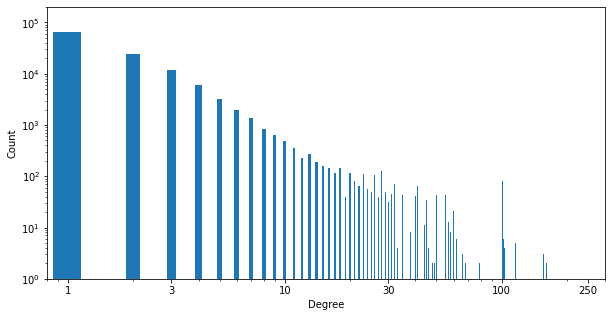

In [27]:
# Axis offsets
offset = {'x' : (0.2, 50),
          'y' : (0,10**5)
          }

# Initialize figure
fig, ax = plt.subplots()
fig.set_size_inches((10,5))
ax.set(xscale="log", yscale="log")

# Plot
ax.bar(degree_sequence, counts, width = 0.3)

# Set xticks
xticks = [1, 3, 10, 30, 100, 250]
xlabels = xticks

plt.xticks(ticks=xticks, labels=xlabels, rotation=0, horizontalalignment = 'center')
plt.xlim(xticks[0] - offset['x'][0], xticks[-1] + offset['x'][1])

# Set yticks
yticks = [10 ** k for k in range(6)]
ylabels = [f'10$^{k}$' for k in range(6)]

plt.yticks(ticks = yticks, labels = ylabels)
plt.ylim(yticks[0] - offset['y'][0], yticks[-1] + offset['y'][1])

# Set axis titles
plt.xlabel("Degree")
plt.ylabel("Count")  

fig.show()

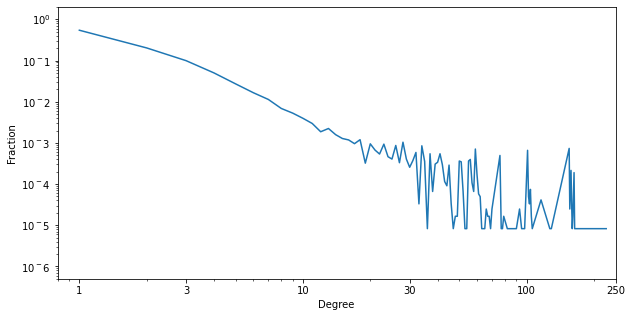

In [28]:
# Axis offsets
offset = {'x' : (0.2, 0.2),
          'y' : (5 * 10**-7,1)
          }

# Initialize figure
fig, ax = plt.subplots()
fig.set_size_inches((10,5))
ax.set(xscale="log", yscale="log")

# Plot
ax.plot(degree_sequence, rel_counts)

# Set xticks
xticks = [1, 3, 10, 30, 100, 250]
xlabels = xticks

plt.xticks(ticks=xticks, labels=xlabels, rotation=0, horizontalalignment = 'center')
plt.xlim(xticks[0] - offset['x'][0], xticks[-1] + offset['x'][1])

# Set yticks
yticks = [10 ** (-6+k) for k in range(7)]
ylabels = [f'10$^{-6+k}$' for k in range(7)]

plt.yticks(ticks = yticks, labels = ylabels)
plt.ylim(yticks[0] - offset['y'][0], yticks[-1] + offset['y'][1])

# Set axis titles
plt.xlabel("Degree")
plt.ylabel("Fraction")  

fig.show()

To shed some light about the cumulative distribution of degrees of this network, the following table shows the total of nodes with degree at most $d$, for different values of $d$. The total number of nodes with positive degree is 121,119.

| Max. degree | Number of nodes | Percentage | 
|:-:|:-:|:-:|
| 3  | 102,689 | 84,78% |
| 5  | 112,042 | 92,51% |
| 10 | 117,373 | 96,91% | 
| 15 | 118,576 | 97.90% | 
| 20 | 119,134 | 98.36% | 
| 25 | 119,498 | 98,66% |
| 30 | 119,849 | 98.95%

Also, the cumulative distribution of degrees is shown.

In [29]:
print_degree_counts([3,5,10,15,20,25,30], degree_sequence, counts)

The total number of nodes with positive degree is 121,119.
 - Nodes with degree at most 3: 102,689 (84.78%).
 - Nodes with degree at most 5: 112,042 (92.51%).
 - Nodes with degree at most 10: 117,373 (96.91%).
 - Nodes with degree at most 15: 118,576 (97.90%).
 - Nodes with degree at most 20: 119,134 (98.36%).
 - Nodes with degree at most 25: 119,498 (98.66%).
 - Nodes with degree at most 30: 119,849 (98.95%).


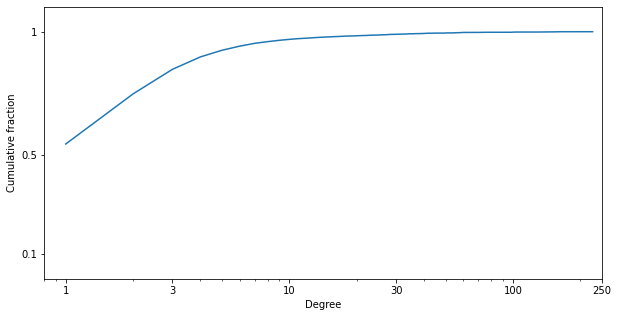

In [30]:
# Axis offsets
offset = {'x' : (0.2, 0.2),
          'y' : (0.1,0.1)
          }

# Initialize figure
fig, ax = plt.subplots()
fig.set_size_inches((10,5))
ax.set(xscale="log")

# Plot
ax.plot(degree_sequence, cum_counts)

# Set xticks
xticks = [1, 3, 10, 30, 100, 250]
xlabels = xticks

plt.xticks(ticks=xticks, labels=xlabels, rotation=0, horizontalalignment = 'center')
plt.xlim(xticks[0] - offset['x'][0], xticks[-1] + offset['x'][1])

# Set yticks
yticks = [0.1, 0.5, 1]
ylabels = yticks

plt.yticks(ticks = yticks, labels = ylabels)
plt.ylim(yticks[0] - offset['y'][0], yticks[-1] + offset['y'][1])

# Set axis titles
plt.xlabel("Degree")
plt.ylabel("Cumulative fraction")  

fig.show()

Finally, another interesting analysis is to detect the number of connected components of the graph. This network posseses 36,086 connected components. Of these, the larges comprises 19,921 nodes, while the smallest only contains 2 nodes.

In [31]:
# Obtain connected components and remove singletons
connected_components = [component for component in nx.connected_components(co_off_graph) if len(component) > 1]
connected_components = sorted(connected_components, key=len, reverse=True)

# Print
print(f'This network has {len(connected_components):,} connected components:')
print(f' - The largest has {len(connected_components[0]):,} nodes.')
print(f' - The smallest has {len(connected_components[-1]):,} nodes.')

This network has 36,086 connected components:
 - The largest has 19,921 nodes.
 - The smallest has 2 nodes.


## (h), (i), (j): Analyze the largest connected component

In [32]:
# Obtain nodes
largest_CC_nodes = connected_components[0]

# Obtain largest connected component as graph
CC_graph = nx.Graph()
CC_graph.add_nodes_from(largest_CC_nodes)
CC_graph.add_edges_from(co_off_graph.edges(largest_CC_nodes))

In [33]:
# Obtain degree distribution
CC_degree_sequence = sorted([d for n, d in CC_graph.degree()])
CC_degree_sequence, CC_counts = np.unique(CC_degree_sequence, return_counts=True)
CC_degree_sequence, CC_counts = CC_degree_sequence, CC_counts

rel_CC_counts = CC_counts/CC_counts.sum()
cum_CC_counts = rel_CC_counts.cumsum()

As mentioned before, the largest connected component comprises 19,921 nodes. This is, approximately, a 16.45% of all nodes with positive degree.

The degree distribution of this connected component does not follow a power-law distribution. However, there seems to be two linear segments: from 1 to 3 and from 3 up to 20. As before, after 20 the lineplot becomes erratic, as there are few nodes with degrees above 20.

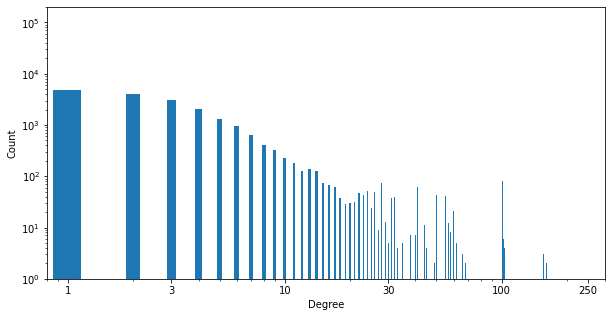

In [34]:
# Axis offsets
offset = {'x' : (0.2, 50),
          'y' : (0,10**5)
          }

# Initialize figure
fig, ax = plt.subplots()
fig.set_size_inches((10,5))
ax.set(xscale="log", yscale="log")

# Plot
ax.bar(CC_degree_sequence, CC_counts, width = 0.3)

# Set xticks
xticks = [1, 3, 10, 30, 100, 250]
xlabels = xticks

plt.xticks(ticks=xticks, labels=xlabels, rotation=0, horizontalalignment = 'center')
plt.xlim(xticks[0] - offset['x'][0], xticks[-1] + offset['x'][1])

# Set yticks
yticks = [10 ** k for k in range(6)]
ylabels = [f'10$^{k}$' for k in range(6)]

plt.yticks(ticks = yticks, labels = ylabels)
plt.ylim(yticks[0] - offset['y'][0], yticks[-1] + offset['y'][1])

# Set axis titles
plt.xlabel("Degree")
plt.ylabel("Count")  

fig.show()

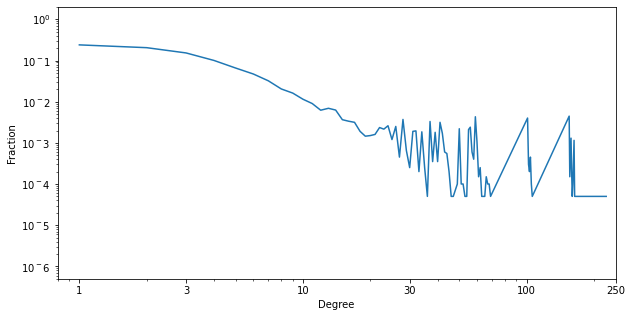

In [35]:
# Axis offsets
offset = {'x' : (0.2, 0.2),
          'y' : (5 * 10**-7,1)
          }

# Initialize figure
fig, ax = plt.subplots()
fig.set_size_inches((10,5))
ax.set(xscale="log", yscale="log")

# Plot
ax.plot(CC_degree_sequence, rel_CC_counts)

# Set xticks
xticks = [1, 3, 10, 30, 100, 250]
xlabels = xticks

plt.xticks(ticks=xticks, labels=xlabels, rotation=0, horizontalalignment = 'center')
plt.xlim(xticks[0] - offset['x'][0], xticks[-1] + offset['x'][1])

# Set yticks
yticks = [10 ** (-6+k) for k in range(7)]
ylabels = [f'10$^{-6+k}$' for k in range(7)]

plt.yticks(ticks = yticks, labels = ylabels)
plt.ylim(yticks[0] - offset['y'][0], yticks[-1] + offset['y'][1])

# Set axis titles
plt.xlabel("Degree")
plt.ylabel("Fraction")  

fig.show()

To shed some light about the cumulative distribution of degrees of this network, the following table shows the total of nodes with degree at most $d$, for different values of $d$. The total number of nodes with positive degree is, by construction, the total number of nodes: 15,119.

| Max. degree | Number of nodes | Percentage | 
|:-:|:-:|:-:|
| 3  | 11,937 | 59,92% |
| 5  | 15,253 | 76.57% |
| 10 | 17,793 | 89.32% | 
| 15 | 18,433 | 92.53% | 
| 20 | 18,660 | 93.67% | 
| 25 | 18,958 | 94.66% |
| 30 | 19,009 | 95.42%

Also, the cumulative distribution of degrees is shown.

In [36]:
print_degree_counts([3,5,10,15,20,25,30], CC_degree_sequence, CC_counts)

The total number of nodes with positive degree is 19,921.
 - Nodes with degree at most 3: 11,937 (59.92%).
 - Nodes with degree at most 5: 15,253 (76.57%).
 - Nodes with degree at most 10: 17,793 (89.32%).
 - Nodes with degree at most 15: 18,433 (92.53%).
 - Nodes with degree at most 20: 18,660 (93.67%).
 - Nodes with degree at most 25: 18,858 (94.66%).
 - Nodes with degree at most 30: 19,009 (95.42%).


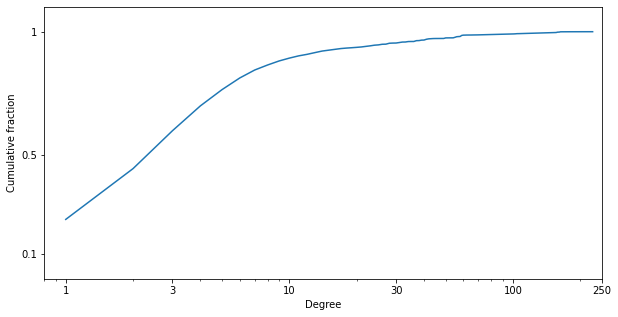

In [37]:
# Axis offsets
offset = {'x' : (0.2, 0.2),
          'y' : (0.1,0.1)
          }

# Initialize figure
fig, ax = plt.subplots()
fig.set_size_inches((10,5))
ax.set(xscale="log")

# Plot
ax.plot(CC_degree_sequence, cum_CC_counts)

# Set xticks
xticks = [1, 3, 10, 30, 100, 250]
xlabels = xticks

plt.xticks(ticks=xticks, labels=xlabels, rotation=0, horizontalalignment = 'center')
plt.xlim(xticks[0] - offset['x'][0], xticks[-1] + offset['x'][1])

# Set yticks
yticks = [0.1, 0.5, 1]
ylabels = yticks

plt.yticks(ticks = yticks, labels = ylabels)
plt.ylim(yticks[0] - offset['y'][0], yticks[-1] + offset['y'][1])

# Set axis titles
plt.xlabel("Degree")
plt.ylabel("Cumulative fraction")  

fig.show()

As opposed to the general network, this connected component has a heavy right tail in the degree distribution. This is expected, as the connected component is a particular subnetwork wher eall the nodes are connected by at least one path. In that sense, it can be possible for the nodes to have a greter degree in general, compared to the original network.

Plotting both cumulative distributions makes this point clear, showing that the largest connected component (blue line) reaches values close to one for degrees much larger than the network as a whole (red line).

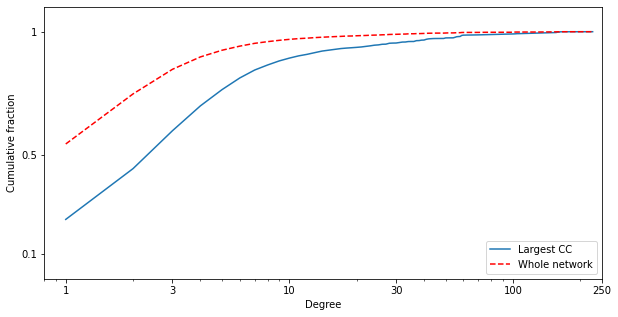

In [38]:
# Axis offsets
offset = {'x' : (0.2, 0.2),
          'y' : (0.1,0.1)
          }

# Initialize figure
fig, ax = plt.subplots()
fig.set_size_inches((10,5))
ax.set(xscale="log")

# Plot
ax.plot(CC_degree_sequence, cum_CC_counts, label='Largest CC')
ax.plot(degree_sequence, cum_counts, color='red', linestyle='--', label='Whole network')

# Set xticks
xticks = [1, 3, 10, 30, 100, 250]
xlabels = xticks

plt.xticks(ticks=xticks, labels=xlabels, rotation=0, horizontalalignment = 'center')
plt.xlim(xticks[0] - offset['x'][0], xticks[-1] + offset['x'][1])

# Set yticks
yticks = [0.1, 0.5, 1]
ylabels = yticks

plt.yticks(ticks = yticks, labels = ylabels)
plt.ylim(yticks[0] - offset['y'][0], yticks[-1] + offset['y'][1])

# Set axis titles
plt.xlabel("Degree")
plt.ylabel("Cumulative fraction")  

# Show legend
plt.legend(loc='lower right')

fig.show()

The diameter of this connected component is 48. In other words, the two most separated nodes are at a distance of 48. In the extreme case where this connected component is a line, the diameter would be the number of nodes minus 1, that is 19,920. This is 415 times the diameter obtained.

In [39]:
eccentricities = get_eccentricities(CC_graph, load=load, file_path = "largest_CC_eccentricities.csv")
print(f"The diameter of the largest connected component is {max(eccentricities.values()):,}.")

The diameter of the largest connected component is 48.


In [40]:
clustering_coefficient = nx.algorithms.approximation.clustering_coefficient.average_clustering(CC_graph, 
                                                                                               trials=CC_graph.number_of_nodes(), 
                                                                                               seed=0)
print(f"The clustering coefficient of the largest component is {clustering_coefficient:.3f}.")

The clustering coefficient of the largest component is 0.478.


In [41]:
print(f"The edge density of the largest component is {nx.function.density(CC_graph):.5f}")

The edge density of the largest component is 0.00036


In [44]:
betweenness_centrality = get_betweenness_centrality(CC_graph, load=load, file_path = "largest_CC_betweenness_centrality.csv")

In [66]:
top_node_loc = int(np.argmax(list(betweenness_centrality.values())))
top_node = list(betweenness_centrality.keys())[top_node_loc]

print(f"The node with most betweenness centrality is node {top_node:,} with a value of {betweenness_centrality[top_node]:.4f}.")
print(f"This node has a degree of {CC_graph.degree[top_node]:,}.")

The node with most betweenness centrality is node 450,875 with a value of 0.1218.
This node has a degree of 15


## (k), (l), (m): Additional questions